In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import geopandas as gp

Reading the location of brackish water wells in Texas

In [31]:
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis.csv')
bw_df_tx = bw_df[bw_df['state_alpha']=='AZ']
bw_df_tx_loc = bw_df_tx[['unique_site_ID','Latitude','Longitude']].copy()
# bw_df_tx_loc

c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


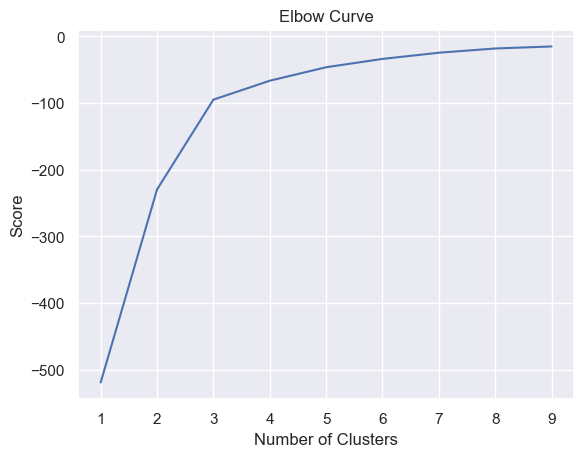

In [32]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = bw_df_tx_loc[['Latitude']]
X_axis = bw_df_tx_loc[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [64]:
# Function to form clusters
def form_cluster(df,n_clusters = 3):
    OMP_NUM_THREADS=1
    kmeans = KMeans(n_clusters = n_clusters, init ='k-means++')
    kmeans.fit(df[df.columns[1:3]]) # Compute k-means clustering.
    df['cluster_label'] = kmeans.fit_predict(df[df.columns[1:3]])
    centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
    labels = kmeans.predict(df[df.columns[1:3]]) # Labels of each point
    centers_array = []
    for idx,row in df.iterrows():
        centers_array.append(centers[int(row['cluster_label'])])
    df['centers'] = centers_array
    return df

temp = form_cluster(bw_df_tx_loc)
max(temp['cluster_label'])

2

In [65]:
bw_df_tx_loc['well_yield'] = bw_df_tx['well_yield']
prev_max_cluster_label = 0

cluster_state_df = pd.DataFrame()
for cluster_id in bw_df_tx_loc['cluster_label'].unique():
    well_yield_total = sum(bw_df_tx_loc[bw_df_tx_loc['cluster_label']==cluster_id]['well_yield'])
    if well_yield_total>5:
        print(cluster_id,well_yield_total)
        print('Number of clusters to not hit maximum capacity:', round(well_yield_total/5))
        cluster_sub_df = bw_df_tx_loc[bw_df_tx_loc['cluster_label']==cluster_id].copy()
        temp_df = form_cluster(cluster_sub_df,n_clusters = round(well_yield_total/5))
        temp_df['cluster_label'] = prev_max_cluster_label + temp_df['cluster_label']
        prev_max_cluster_label = max(temp_df['cluster_label'])

        cluster_state_df = pd.concat([cluster_state_df,temp_df],ignore_index=True)

cluster_state_df.head()
        

1 160.9803959578755
Number of clusters to not hit maximum capacity: 32
2 54.4278743488122
Number of clusters to not hit maximum capacity: 11
0 6.150665804453561
Number of clusters to not hit maximum capacity: 1


c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mhardika\miniconda3\envs\watertap3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,unique_site_ID,Latitude,Longitude,cluster_label,well_yield,centers
0,AZ_GEOTH-AZ0183,32.639722,-111.945833,7,0.031545,"[32.71791089, -111.9385088]"
1,AZ_GEOTH-AZ0274,32.850556,-111.584444,27,0.070667,"[32.903216495555554, -111.62038867111112]"
2,AZ_GEOTH-AZ0297,32.894444,-111.558611,27,0.125000,"[32.903216495555554, -111.62038867111112]"
3,AZ_GEOTH-AZ0327,32.931111,-111.550000,1,0.037854,"[32.943800439726026, -111.51490722054794]"
4,AZ_GEOTH-AZ0338,32.936944,-111.566944,1,0.063000,"[32.943800439726026, -111.51490722054794]"


In [66]:
us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")

state_code = '04'
state = us_counties.loc[us_counties['STATEFP']==state_code]

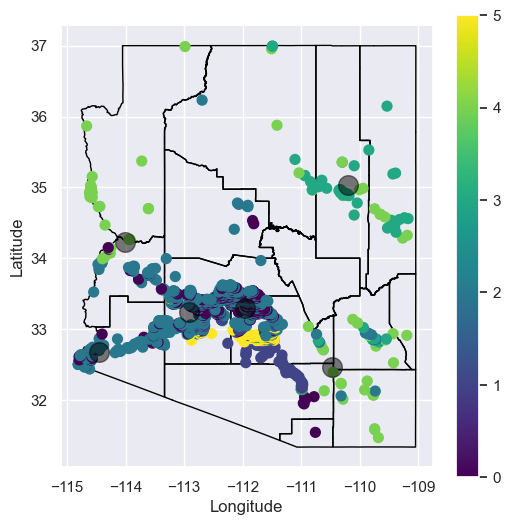

In [67]:
fig, ax = plt.subplots(figsize = (6,6))
state.plot(ax=ax,facecolor ='none',edgecolor ='black')
cluster_state_df.plot.scatter(ax=ax, x = 'Longitude', y = 'Latitude', c=labels, s=50, cmap='viridis')
ax.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)


Code to iteratively figure out clusters to form

In [ ]:
# Check total volume being treated

# Take cluster with extra points. Calculate how many subclusters the cluster should have. 

# Find centroid. Reassign cluster number